# Getting the data

In [42]:
from pyspark import SparkContext, SparkConf
from math import sqrt,log
from random import randint, random, randrange,uniform
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

sc = SparkContext.getOrCreate()
sc.stop()

conf = SparkConf().setAppName("kmeans").setMaster("local[*]")
sc = SparkContext(conf=conf)

* Getting data from S-sets : https://cs.joensuu.fi/sipu/datasets/
* Using the s1 dataset

In [43]:
s1 = sc.textFile("../data/s1.txt")


def extract_split(x):
    splits = x.split('    ')
    return (int(splits[1]), int(splits[2]))

s1 = s1.flatMap(lambda x: x.split('\n')).map(extract_split)

s1 = s1.sample(withReplacement=False,fraction=0.5)

In [44]:
s1.takeSample(False, 20)

[(177505, 332053),
 (605891, 428146),
 (529858, 213114),
 (350428, 392503),
 (356500, 188114),
 (850453, 155432),
 (851866, 156896),
 (240308, 844341),
 (871544, 592403),
 (138073, 556272),
 (757470, 224976),
 (185561, 342784),
 (757421, 774445),
 (271093, 861412),
 (105444, 361358),
 (839757, 190518),
 (864721, 548447),
 (336549, 565597),
 (588952, 437524),
 (418623, 404382)]

# Kmeans ++ intitialization

In [45]:
def compute_distance(xi_indexes, yi_indexes):
    def map(row):
        sum = 0
        for i in range(len(xi_indexes)):
            sum += (row[yi_indexes[i]] - row[xi_indexes[i]]) ** 2
        distance = sqrt(sum)
        return row + (distance,)
    return map


In [46]:
def reduceMax(dist_indexes):
    def reduce_custom(x1,x2):
        '''
        print("\n")
        '''
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        '''
        print("------")
        
        print("X1 :", x1[0], x1[1])
        print("Dist x1 : ",dist_x1)
        '''
        mindist_x1 =  min(dist_x1)
        
        '''
        print("Min dist x1 :", mindist_x1)
        
        print("X2 :", x2[0], x2[1])
        print("Dist x2 : ", dist_x2)
        '''
        mindist_x2 = min(dist_x2)
        '''
        print("Min dist x2 :", mindist_x2)
        print("------")
        '''
        
        
        result = None
        if(mindist_x1 > mindist_x2):
            result = x1
        else:
            result = x2
        
        '''
        print("Result :", result[0], result[1])
        
        '''
        return result
        
        
    return reduce_custom



In [47]:
def reduceMaxSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [48]:
def reduceMaxAverage(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)/len(dist_x1)
        mindist_x2 = sum(dist_x2)/len(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [49]:
def mapDistance(dist_indexes):
    def custom_map(row):
        index = row[0]
        table = row[1]
        dists = []
        for idx in dist_indexes:
            dists.append(table[idx])

        min_dist = min(dists)

        return (index, min_dist)
    return custom_map

def basicMaxReduce(x1,x2):
    return max(x1,x2)


def findNextCenter(data, dist_indexes, coord_indexes):
    dataZip = data.zipWithIndex().map(lambda x : (x[1],x[0]))
    print ("Data zip", dataZip.take(3))
    
    #Map Min Dist
    dataZipMap = dataZip.map(mapDistance(dist_indexes))
    print ("Data zip map", dataZipMap.take(3))

    #Normalize distance
    nc = dataZipMap.map(lambda x: x[1])
    
    print ("Data to extract max dist", nc.take(3))
    
    nc = nc.reduce(lambda a,b:a+b)
    
    
    print("Full cumulative sum is  : ", nc)
    
    dataZipMap = dataZipMap.map(lambda x: (x[0], x[1]/nc) )
    
    print("Data zip map normalized ", dataZipMap.take(3))
    
    collection = dataZipMap.collect()
    print(collection[:3])
    
    #Draw best point
    indexes = [item[0] for item in collection]
    prob = [item[1] for item in collection]
    
    print(indexes[:3])
    print(prob[:3])
    print(sum(prob))
    
    cumsum = np.cumsum(prob)
    
    index_best_point = None
    
    draw = uniform(0,1)
    print("Draw : ", draw)
    print("Cumsum 0", cumsum[0])
    if(draw < cumsum[0]):
        index_best_point = indexes[0]
    else:
        current_index = 1
        current_sum = cumsum[current_index]
        previous_sum = cumsum[current_index -1]
        while not(draw < current_sum and draw >= previous_sum):
            #print("Index loop ", current_index)
            #print("Current sum ", current_sum)
            #print("Previous sum", previous_sum)
            
            current_index += 1
            previous_sum = cumsum[current_index -1]
            current_sum = cumsum[current_index]
            
        index_best_point = current_index
    
    best_point = dataZip.filter(lambda x: x[0] == index_best_point).collect()
    print("Best point ", best_point)
    result = tuple([best_point[0][1][coord] for coord in coord_indexes])
    print(result)
    return result

In [50]:
def reduceMaxWithRandom(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  min(dist_x1)
        mindist_x2 = min(dist_x2)
        
        
        draw = uniform(0,mindist_x1 + mindist_x2)    
        
        '''
        print("\n")
        print("X1 :", x1[0], x1[1])
        print("X2 :", x2[0], x2[1])
        
        print("Min_dist x1 :", mindist_x1)
        print("Min_dist x2 :", mindist_x2)
        print("Draw : ", draw)
        '''
        result = x1
        if(draw > mindist_x1):
            result = x2
            
        #print ("Result : ",result[0], result[1])
        return result
        
            
    return reduce_custom

In [51]:
def reduceMaxWithRandomSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        draw = uniform(0,mindist_x1 + mindist_x2)    
            
        result = x1
        if(draw > mindist_x1):
            result = x2
        return result
        
            
    return reduce_custom

In [52]:
def compute_average(list_reduce, coord_indexes):
    result = ()
    for idx in coord_indexes:
        coord_list = [reduce_tuple[1][idx] for reduce_tuple in list_reduce]
        average = sum(coord_list)/len(coord_list)
        result += (average,)
    return result
        

In [53]:
def drawGraph(data, cluster_centers):
    datalist = data.collect()
    plt.figure()
    x = [point[0] for point in datalist]
    y = [point[1] for point in datalist]
    
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x,y,'bs', x_clusters, y_clusters, 'r^')

In [54]:
def mapAddTuple(t, coord_idx):
    def map(row):
        
        toAdd = tuple([deepcopy(t[i]) for i in coord_idx])
        
        return row + toAdd
    return map

In [55]:
def initCluster(data,num_clusters,num_features, reducer, cluster_centers, visualize=False, distributed = True):
    xi_indexes = [idx for idx in range(0,num_features)]
    yi_indexes = [idx for idx in range(num_features, num_features*2)]
    coord_indexes = [idx for idx in range(num_features)]
    dist_indexes = [num_features*2]
    current_clust = 2
    
    '''
    print("Initial xi_indexes : ", xi_indexes)
    print("Initial yi_indexes : ", yi_indexes)
    print("Initial coord_indexes : ",coord_indexes)
    print("Initial dist_indexes : ", dist_indexes)
    print("Intial current_clust :", current_clust)
    print("\n")
    '''
    
    for _ in range(num_clusters-1):
        
        #print("#############################")
        
        
        print("Current cluster points :", cluster_centers)
        '''
        print("Data before adding distance")
        collect = data.collect()
        for line in data.collect():
            print(line, "\n")
        '''
        
        data_dist = data.map(compute_distance(xi_indexes, yi_indexes))
        
        
        
        
        if not distributed:
            new_cluster_point = findNextCenter(coord_indexes=coord_indexes,data=data_dist,dist_indexes=dist_indexes)
        else:
            '''
            print("\n Data with distance")
            for line in data_dist.collect():
                print(line, "\n")

            '''
            reduce_tuple = data_dist.reduce(reducer(dist_indexes=dist_indexes))

            ''' 
            print("\n Data after reduce")
            for line in data_dist.collect():
                print(line, "\n")
            '''
        
        
            new_cluster_point = tuple(reduce_tuple[i] for i in coord_indexes)
            
        cluster_centers.append(new_cluster_point)
        
        
        print("\n Cluster list : ", cluster_centers)
                                  
        #print("Computing center of cluster n° {}".format(current_clust))
        print("\n New cluster point : {}".format(new_cluster_point))
        
        
        
        
        #CE MAP ETAIT LA SOURCE DES SOUCIS, JAI ENCAPSULE LE CODE DANS UNE FONCTIOn
        data_point = data_dist.map(mapAddTuple(new_cluster_point,coord_idx=coord_indexes))
                        
        
        
        
        data = data_point
        
        data_point.count()
        
        '''
        print("\n Data after adding new cluster point")
        for line in data_point.collect():
            print(line, "\n")
        '''
        
        if visualize:
            #Assume that data is 2D, and coord is 0,1
            drawGraph(data, cluster_centers)
        
        #Update of variables
        current_clust += 1
        dist_indexes.append(current_clust*num_features + current_clust - 2)
        yi_indexes = [old_value + num_features + 1 for old_value in yi_indexes]
        
        #print("New yi indexes : {}".format(yi_indexes))
        #print("New dist_indexes : {}".format(dist_indexes))
        
        '''
        print("\n")
        print("##############################")
        '''
    return data, cluster_centers
        


Initial cluster center :  (677769, 841641) 

Current cluster points : [(677769, 841641)]
Data zip [(0, (665845, 557965, 677769, 841641, 283926.495332859)), (1, (597173, 575538, 677769, 841641, 278040.5039288341)), (2, (618600, 551446, 677769, 841641, 296165.6775961725))]
Data zip map [(0, 283926.495332859), (1, 278040.5039288341), (2, 296165.6775961725)]
Data to extract max dist [283926.495332859, 278040.5039288341, 296165.6775961725]
Full cumulative sum is  :  1194857817.4037464
Data zip map normalized  [(0, 0.00023762366634533163), (1, 0.00023269756441228798), (2, 0.00024786687862133906)]
[(0, 0.00023762366634533163), (1, 0.00023269756441228798), (2, 0.00024786687862133906)]
[0, 1, 2]
[0.00023762366634533163, 0.00023269756441228798, 0.00024786687862133906]
0.9999999999999997
Draw :  0.15893195765934587
Cumsum 0 0.000237623666345
Best point  [(569, (817018, 729596, 677769, 841641, 178729.868869196))]
(817018, 729596)

 Cluster list :  [(677769, 841641), (817018, 729596)]

 New cluster

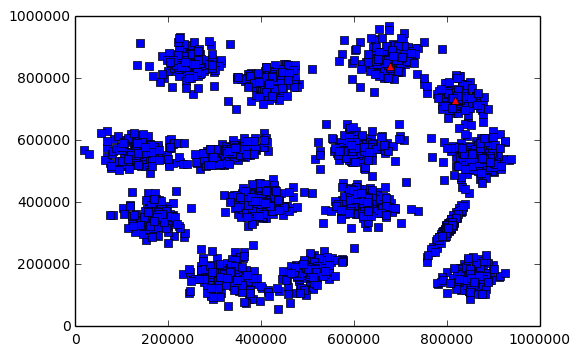

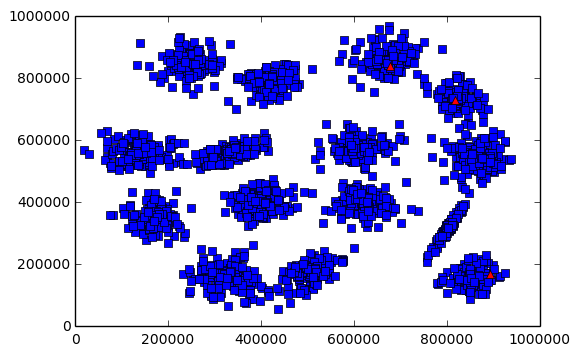

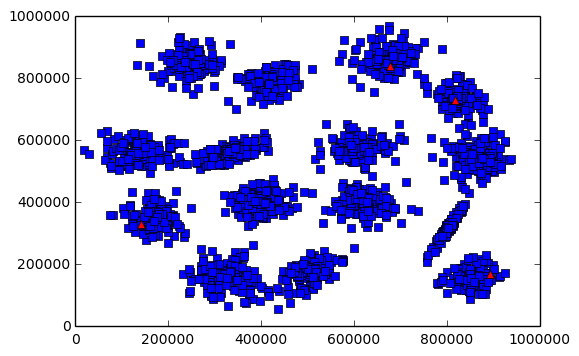

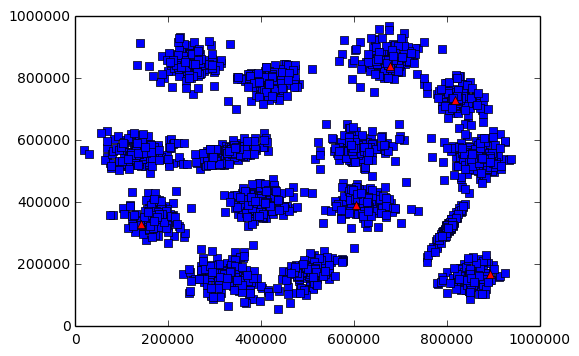

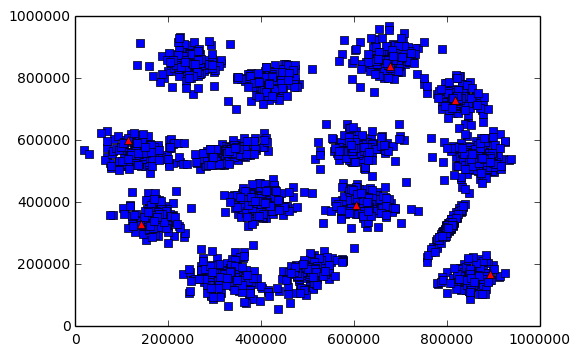

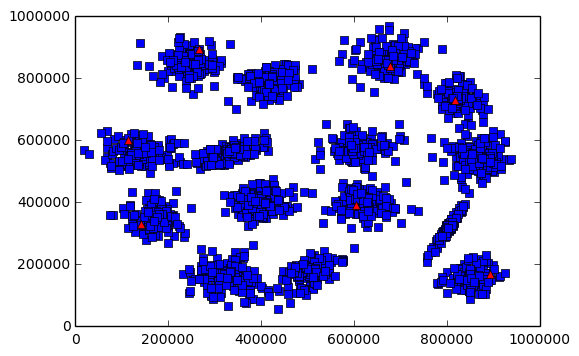

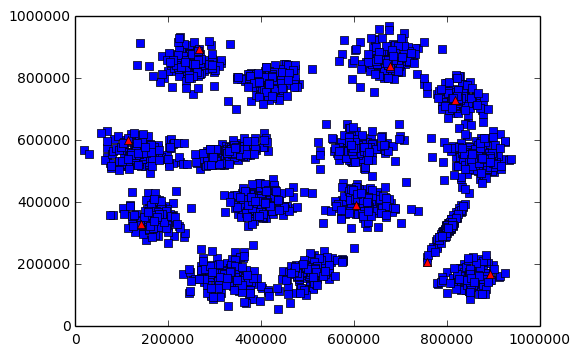

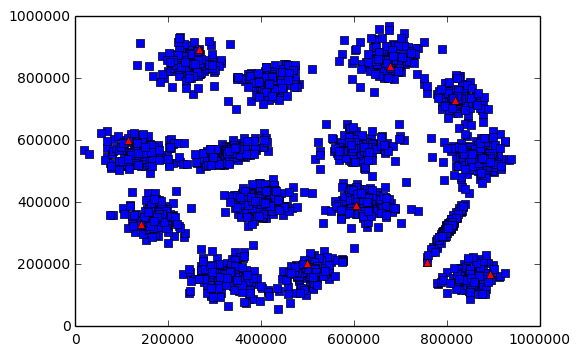

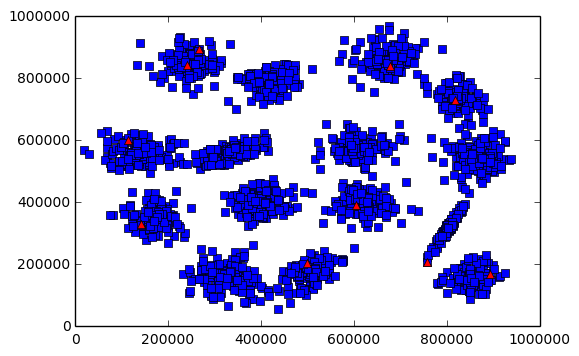

In [56]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True, distributed=False)


print(cluster_centers)

Initial cluster center :  (209922, 850026) 

Current cluster points : [(209922, 850026)]

 Cluster list :  [(209922, 850026), (881106, 105566)]

 New cluster point : (881106, 105566)
Current cluster points : [(209922, 850026), (881106, 105566)]

 Cluster list :  [(209922, 850026), (881106, 105566), (232784, 169847)]

 New cluster point : (232784, 169847)
Current cluster points : [(209922, 850026), (881106, 105566), (232784, 169847)]

 Cluster list :  [(209922, 850026), (881106, 105566), (232784, 169847), (866760, 753547)]

 New cluster point : (866760, 753547)
Current cluster points : [(209922, 850026), (881106, 105566), (232784, 169847), (866760, 753547)]

 Cluster list :  [(209922, 850026), (881106, 105566), (232784, 169847), (866760, 753547), (587478, 424878)]

 New cluster point : (587478, 424878)
Current cluster points : [(209922, 850026), (881106, 105566), (232784, 169847), (866760, 753547), (587478, 424878)]

 Cluster list :  [(209922, 850026), (881106, 105566), (232784, 169847)

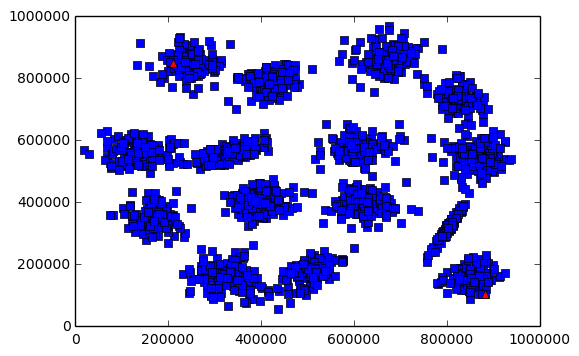

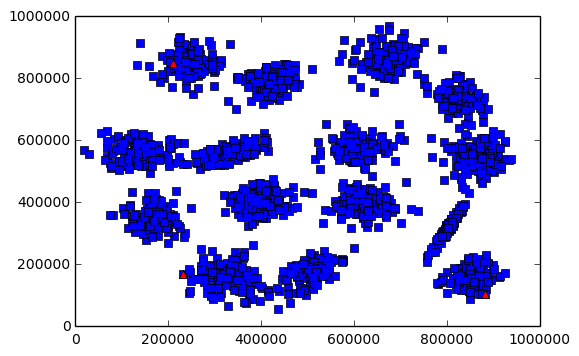

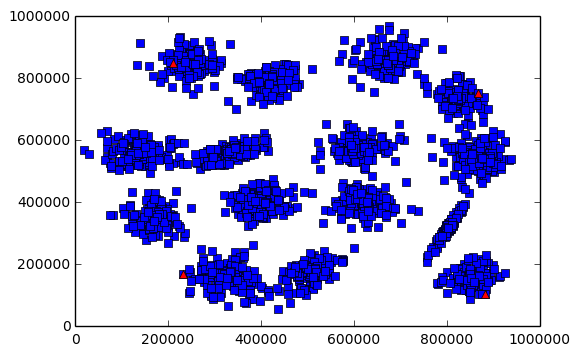

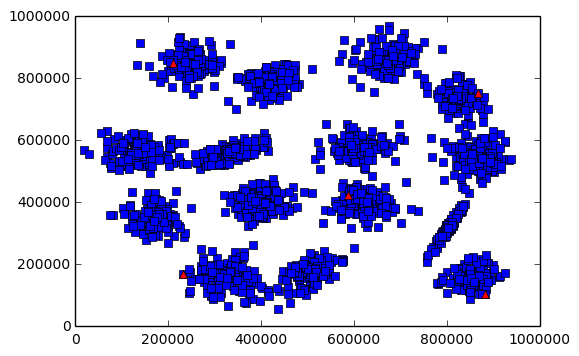

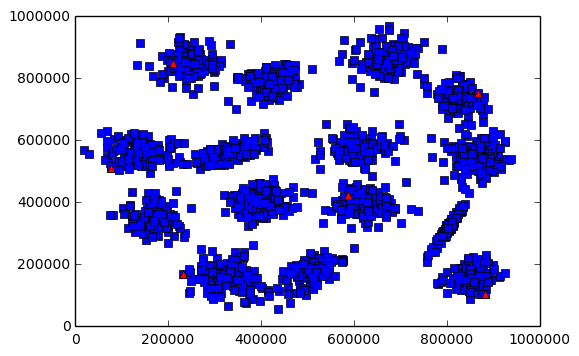

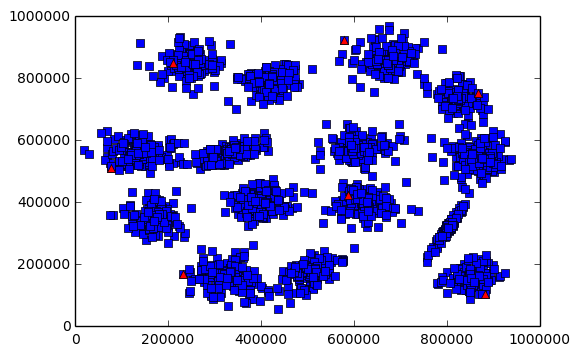

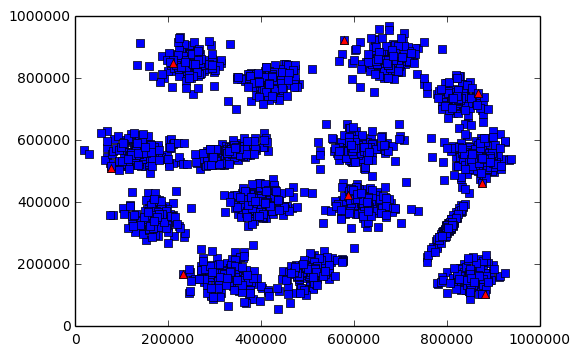

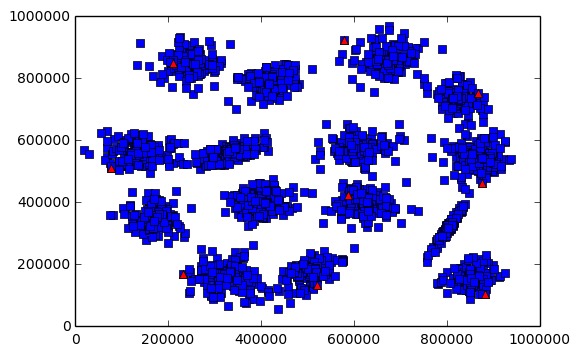

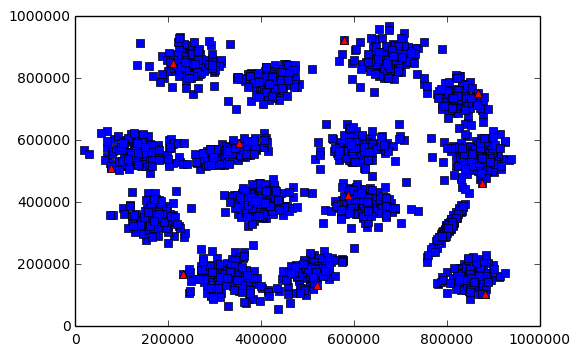

In [57]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)


print(cluster_centers)

Initial cluster center :  (209922, 850026) 

Current cluster points : [(209922, 850026)]

 Cluster list :  [(209922, 850026), (650661, 861267)]

 New cluster point : (650661, 861267)
Current cluster points : [(209922, 850026), (650661, 861267)]

 Cluster list :  [(209922, 850026), (650661, 861267), (618053, 357534)]

 New cluster point : (618053, 357534)
Current cluster points : [(209922, 850026), (650661, 861267), (618053, 357534)]

 Cluster list :  [(209922, 850026), (650661, 861267), (618053, 357534), (701017, 931252)]

 New cluster point : (701017, 931252)
Current cluster points : [(209922, 850026), (650661, 861267), (618053, 357534), (701017, 931252)]

 Cluster list :  [(209922, 850026), (650661, 861267), (618053, 357534), (701017, 931252), (605891, 428146)]

 New cluster point : (605891, 428146)
Current cluster points : [(209922, 850026), (650661, 861267), (618053, 357534), (701017, 931252), (605891, 428146)]

 Cluster list :  [(209922, 850026), (650661, 861267), (618053, 357534)

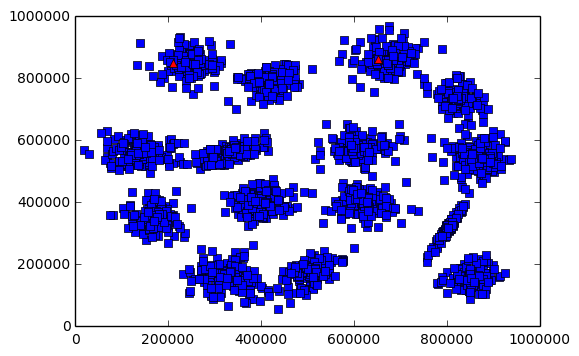

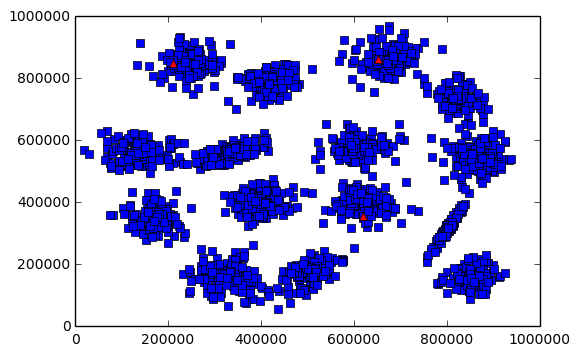

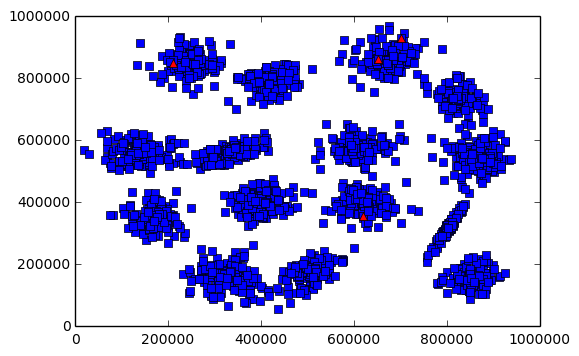

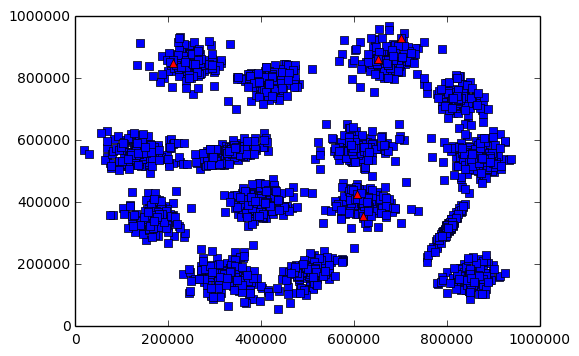

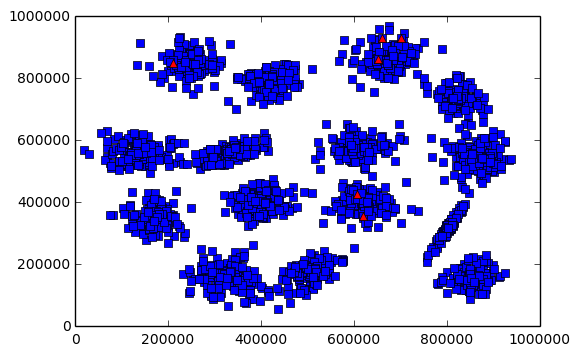

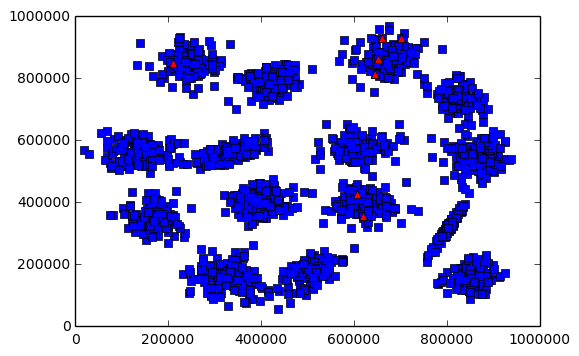

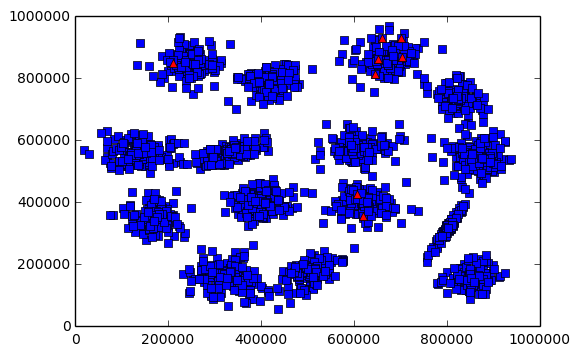

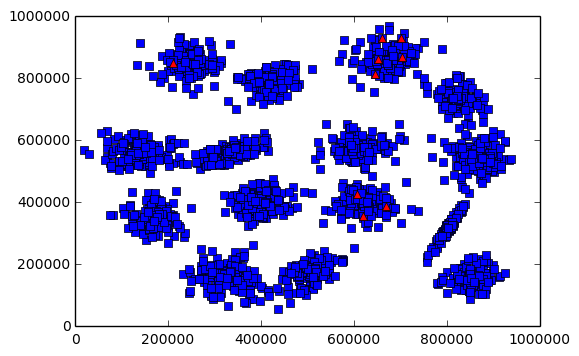

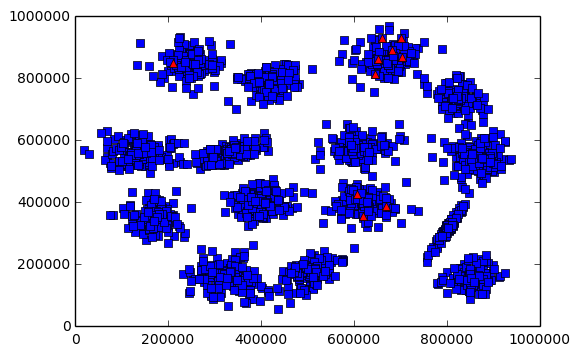

In [58]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandom,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (209922, 850026) 

Current cluster points : [(209922, 850026)]

 Cluster list :  [(209922, 850026), (881106, 105566)]

 New cluster point : (881106, 105566)
Current cluster points : [(209922, 850026), (881106, 105566)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229)]

 New cluster point : (245783, 109229)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634)]

 New cluster point : (789095, 895634)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634), (19835, 570290)]

 New cluster point : (19835, 570290)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634), (19835, 570290)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (

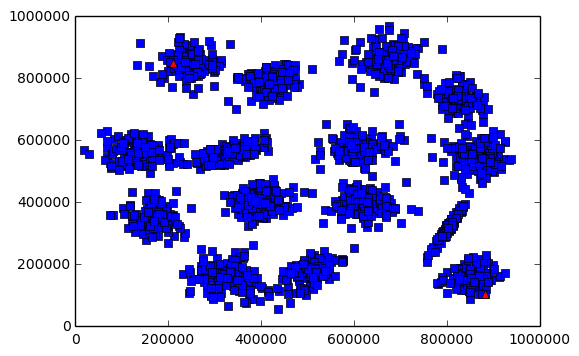

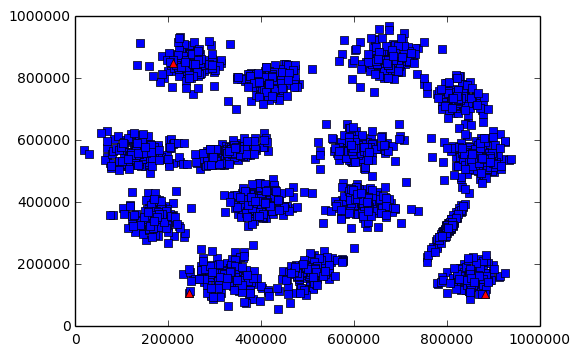

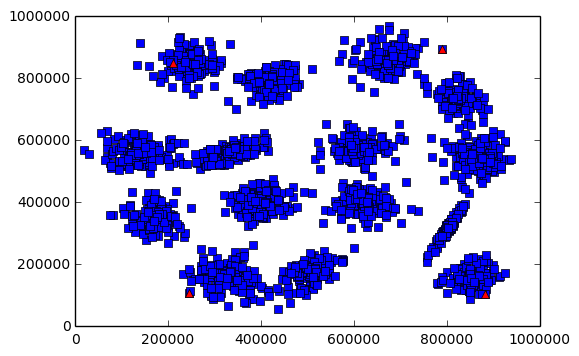

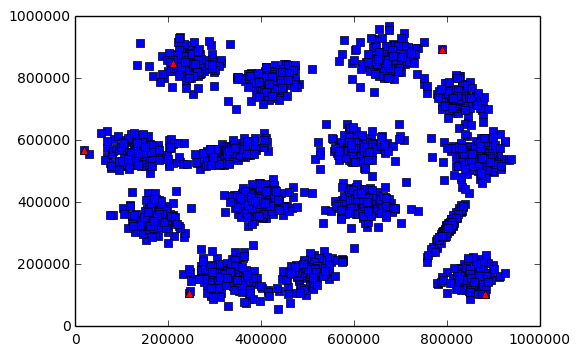

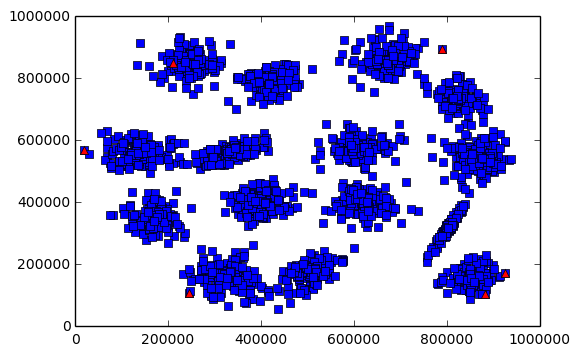

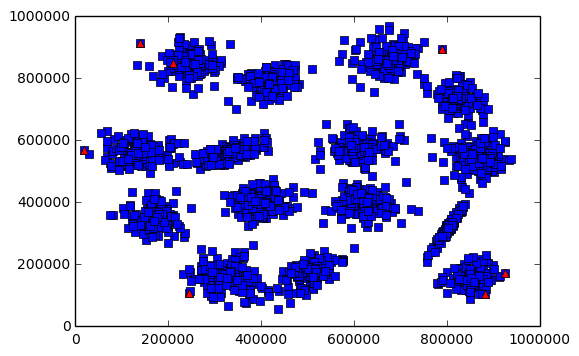

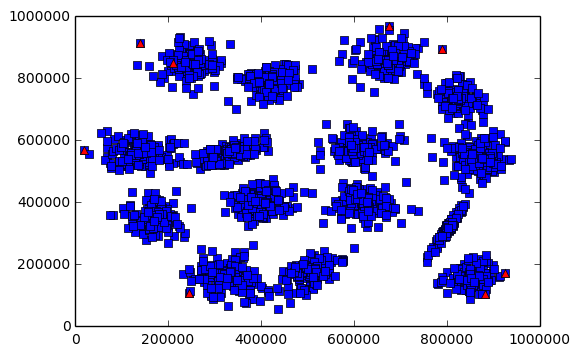

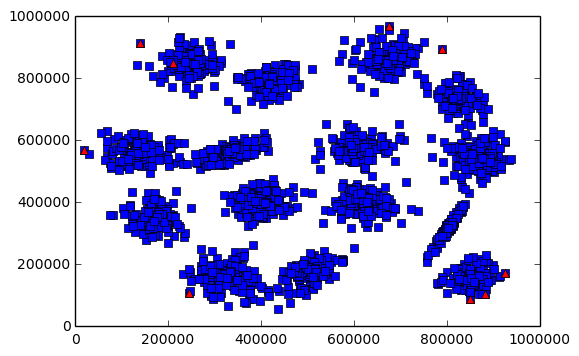

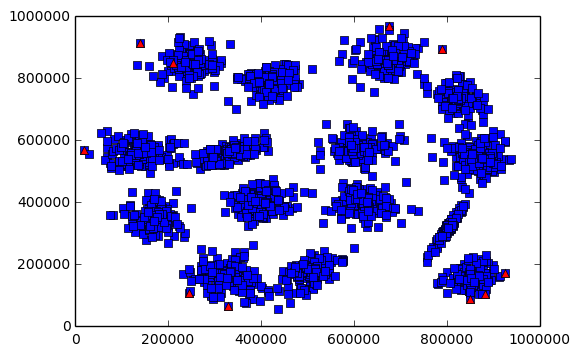

In [59]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxSum,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (209922, 850026) 

Current cluster points : [(209922, 850026)]

 Cluster list :  [(209922, 850026), (881106, 105566)]

 New cluster point : (881106, 105566)
Current cluster points : [(209922, 850026), (881106, 105566)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229)]

 New cluster point : (245783, 109229)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634)]

 New cluster point : (789095, 895634)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634), (19835, 570290)]

 New cluster point : (19835, 570290)
Current cluster points : [(209922, 850026), (881106, 105566), (245783, 109229), (789095, 895634), (19835, 570290)]

 Cluster list :  [(209922, 850026), (881106, 105566), (245783, 109229), (

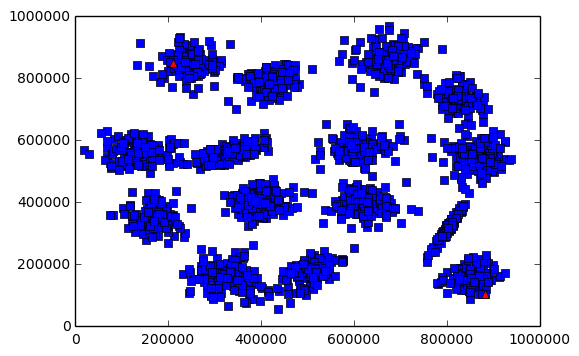

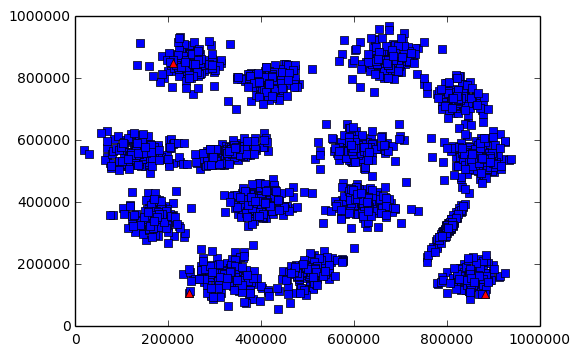

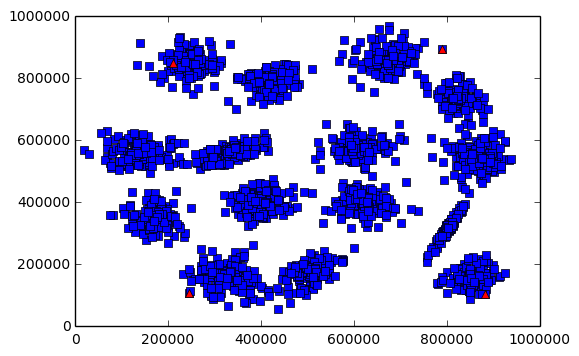

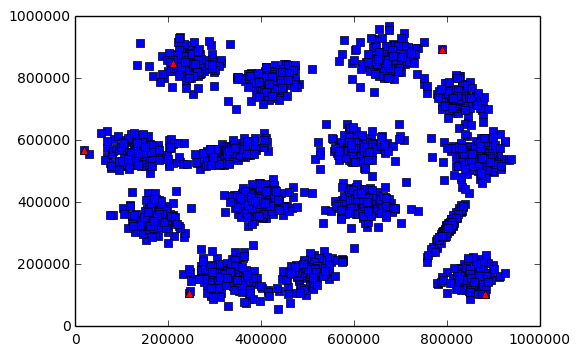

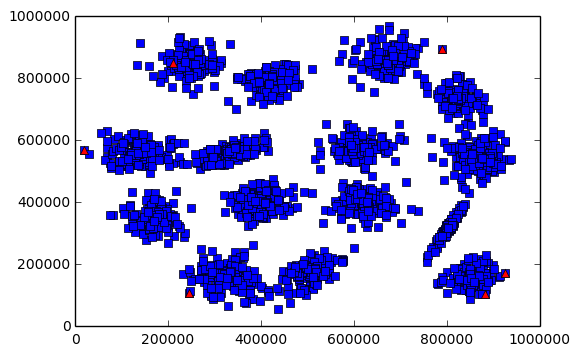

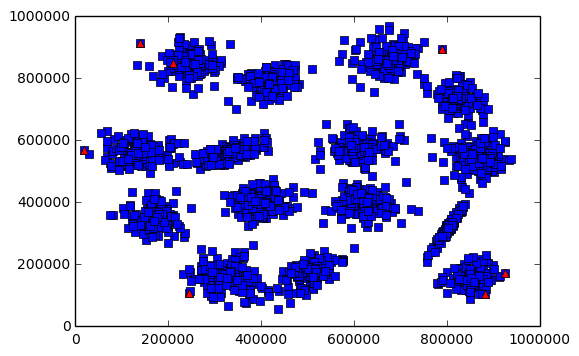

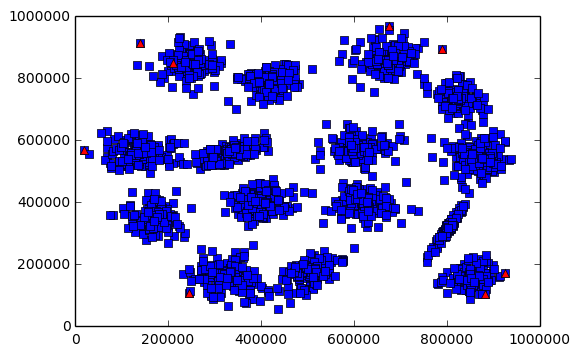

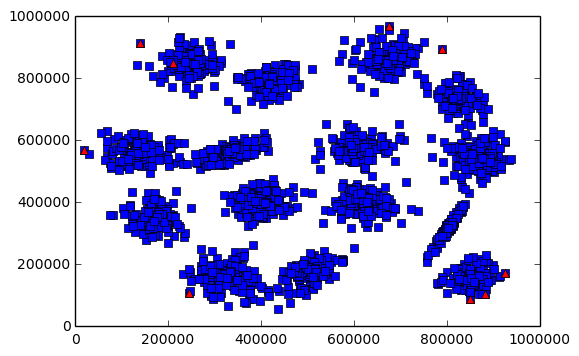

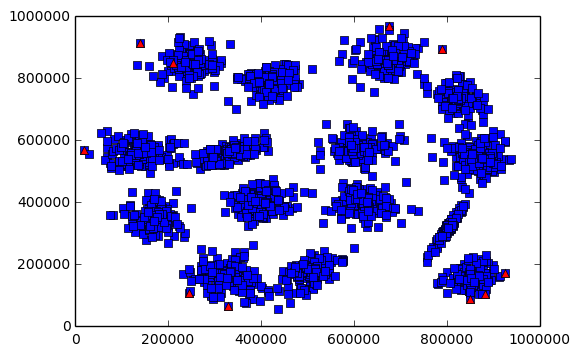

In [60]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxAverage,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (209922, 850026) 

Current cluster points : [(209922, 850026)]

 Cluster list :  [(209922, 850026), (588933, 366439)]

 New cluster point : (588933, 366439)
Current cluster points : [(209922, 850026), (588933, 366439)]

 Cluster list :  [(209922, 850026), (588933, 366439), (605891, 428146)]

 New cluster point : (605891, 428146)
Current cluster points : [(209922, 850026), (588933, 366439), (605891, 428146)]

 Cluster list :  [(209922, 850026), (588933, 366439), (605891, 428146), (650661, 861267)]

 New cluster point : (650661, 861267)
Current cluster points : [(209922, 850026), (588933, 366439), (605891, 428146), (650661, 861267)]

 Cluster list :  [(209922, 850026), (588933, 366439), (605891, 428146), (650661, 861267), (591955, 378142)]

 New cluster point : (591955, 378142)
Current cluster points : [(209922, 850026), (588933, 366439), (605891, 428146), (650661, 861267), (591955, 378142)]

 Cluster list :  [(209922, 850026), (588933, 366439), (605891, 428146)

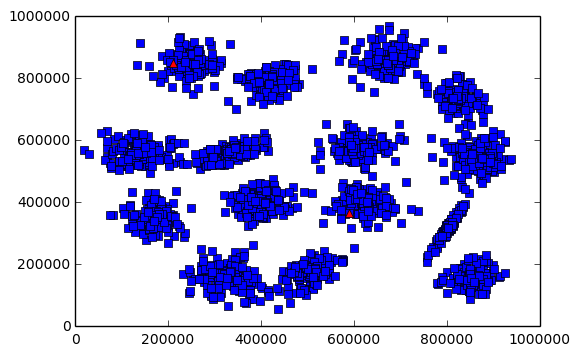

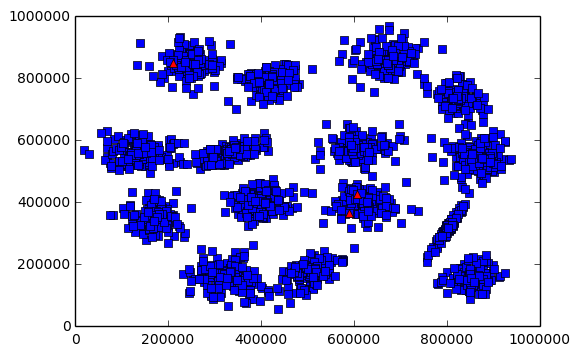

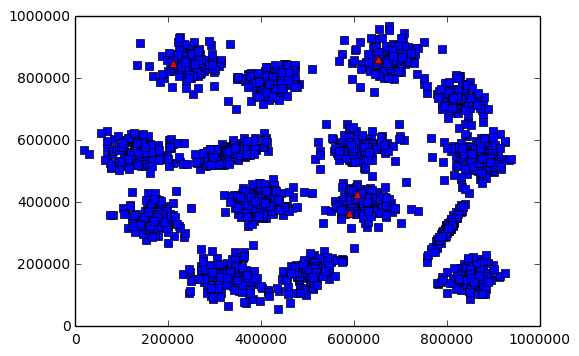

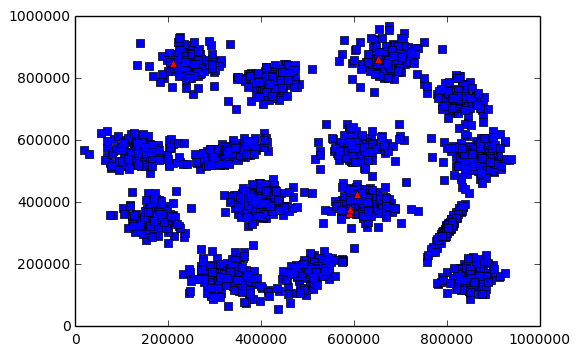

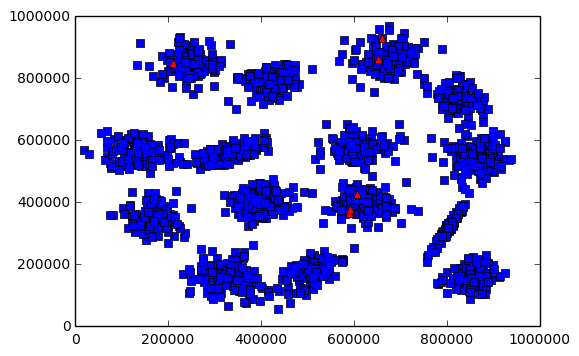

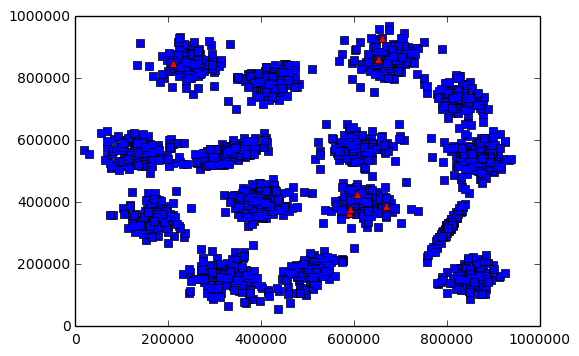

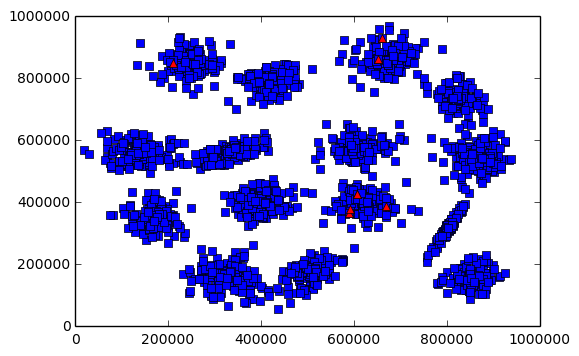

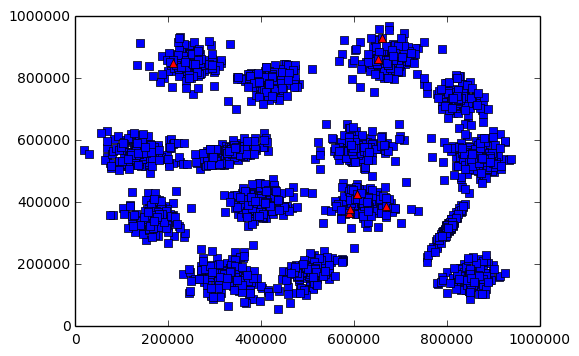

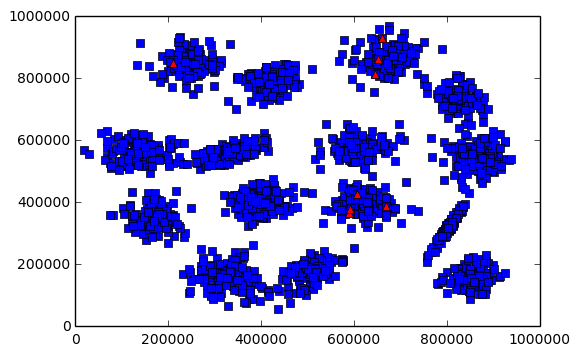

In [61]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandomSum,  cluster_centers=cluster_centers, visualize=True)


In [62]:
max(2,3)

3

Code pour kmeans et la visualisation de  => visualisation toutes les 10 itérations

In [63]:
def distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x2[i] - x1[i]) ** 2
    
    distance_result = sqrt(sum)
    
    return distance_result


#L X Y X1 Y1 D1 X2 Y2 D2 X3 Y3 D3
#0 1 2 3  4  5  6  7  8  9  10 11
def computeCluster(num_features, num_clusters):
    def map_cluster(row):
        
        #print("====== \n Map compute cluster distance")
        index_coord = [index for index in range(1,num_features + 1)]
        #print("index coords :", index_coord)
        
        coords_value = [row[index] for index in index_coord]
            
        indexes_clusters = [[index_cluster*num_features + index_features + index_cluster for index_features in range(0,num_features)] for index_cluster in range(1, num_clusters+ 1)]
        #print("index centers initial : ", indexes_clusters)
        
        indexes_distance = [index_cluster*num_features + index_cluster - 1 for index_cluster in range(2, num_clusters+ 2)]
        #print("indexes distance : ", indexes_distance)
        
        cluster_distances = []
        
        for cluster_coord_idx in indexes_clusters :
            
            coords_cluster = [row[index] for index in cluster_coord_idx]
            
            distance_cluster = distance(coords_value, coords_cluster)
            #print("Coord cluster ", coords_cluster)
            #print("Coord value ", coords_value)
            #print("Distance : ", distance_cluster)
            
            cluster_distances.append(distance_cluster)
            
        #print("Cluster distance array ", cluster_distances)
        
        index_max = np.argmin(cluster_distances) + 1
        #print("Index min : ", index_max)
        row_list = list(row)
        row_list[0] = index_max
        
        row = tuple(row_list)
        
        #print("========")
        
        return row
    return map_cluster
    
def formatDataReduce(num_features, num_clusters):
    def map_format(row):
        cluster = row[0]
        #indexes_clusters = [cluster * num_features + index_features + cluster for index_features in range(0,num_features)]
        indexes_coords = [index for index in range(1,num_features + 1)]
        
        coords_value = [row[index] for index in indexes_coords]
        #coords_cluster = [row[index] for index in indexes_clusters]
        
        return (cluster, (coords_value,1))
    return map_format

def reduceComputeCenter(num_features):
    def reduce_center(x1,x2):
        
        #print("X1 ", x1)
        #print("X2", x2)
        
        
        coords_x1 = x1[0]
        coords_x2 = x2[0]
        
        #print("Coords x1 ", coords_x1)
        #print("Coords x2", coords_x2)
        coords_sum = [coords_x1[i] + coords_x2[i] for i in range(0, num_features)]
        
        #print("Sum of coords", coords_sum)
        
        x1_num = x1[1]
        x2_num = x2[1]
        
        return tuple([coords_sum, x1_num + x2_num])
    return reduce_center

def updateClusterCoords(num_features, num_clusters, reduce):
    def map_update_cluster(row):
        
        #print("Reduce : ", reduce)
        indexes_clusters = [[index_cluster*num_features + index_features + index_cluster for index_features in range(0,num_features)] for index_cluster in range(1, num_clusters+ 1)]
        
        #print("index centers : ", indexes_clusters)
        
        num_cluster_real = len(reduce)
        for cluster in range(0,num_cluster_real):
            new_coordinates = reduce[cluster][1]
            cluster_center_indexes = indexes_clusters[cluster]
            
            for i in range(len(cluster_center_indexes)):
                row_list = list(row)
                row_list[cluster_center_indexes[i]] = new_coordinates[i]
                row = tuple(row_list)
        
        return row
            
        
        
    return map_update_cluster

def getRandomColor():
    return '#{:06x}'.format(randint(0, 0xffffff))    
    
def drawKmeans(data, cluster_centers, colorlist):
    datalist = data.collect()
    plt.figure()
    
    dict_point = {}
    
    for point in datalist:
        cluster = point[0]
        pointdict = dict_point.get(cluster, {})
        pointlist = pointdict.get("points",[])
        pointdict["color"] = colorlist[cluster - 1]
        
        pointlist.append([point[1],point[2]])
        pointdict["points"] = pointlist
        
        dict_point[cluster] = pointdict
    
    #print("Dict point ", dict_point)
    
    for key in dict_point:
        pointlist = dict_point[key]["points"]
        color = dict_point[key]["color"]
        
        x = [item[0] for item in pointlist]
        y = [item[1] for item in pointlist]
        
        #print("Color ", color)
        #print("X ", x)
        #print("Y ",y)
        plt.scatter(x,y,color = color, marker="s")
        
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x_clusters, y_clusters, 'r^')
    
def kmeans(data, cluster_centers, num_iterations, num_features, visualize=False):
    if visualize:
        colorlist = [getRandomColor() for i in range(len(cluster_centers))]

    num_clusters = len(cluster_centers)
    #print("Num clusters :", num_clusters, "\n")
    
    #Cluster is first in the tuple
    data = data.map(lambda x : (-1,) + x)
    
    #print("Data with empty cluster", data.take(3), "\n")
    data = data.map(computeCluster(num_features, num_clusters))
    
    #print("Data with cluster", data.take(3), "\n")
    
    for it in range(num_iterations):
        dataReduce = data.map(formatDataReduce(num_features, num_clusters))
        #print("Data prepared for the reduce :", dataReduce.take(3), "\n")
        
        reduce = dataReduce.reduceByKey(reduceComputeCenter(num_features))
        collect = reduce.collect()
        #print("Collect : ", collect)
        
        #COMPUTE AVERAGE
        reduce_list = []
        
        #tuple reduce : ( 1, ([2,3,4], 112))
        for tuple_reduce in reduce.collect():
            cluster = tuple_reduce[0]
            
            tuple_value = tuple_reduce[1]
            
            coord_list = tuple_value[0]
            
            num_point = tuple_value[1]
            
            for i in range(0,num_features):
                coord_list[i] = coord_list[i] / num_point
            
            reduce_list.append( (cluster, coord_list) )
        
        #print("Result of reduce : ", reduce_list, "\n")
        
        
        #reduce list :  (1, [2,3,4])
        data = data.map(updateClusterCoords(num_features, num_clusters, reduce_list))
        #print("Result of map update coords :", data.take(3), "\n")
        
        data = data.map(computeCluster(num_features, num_clusters))
        #print("Data with updated cluster", data.take(3), "\n")
        
        if visualize and (it %10 == 0):
            cluster_centers = []
            for tuple_reduce in reduce_list:
                cluster_centers.append([tuple_reduce[1][0],tuple_reduce[1][1]])
            
        
            drawKmeans(data = data, cluster_centers=cluster_centers, colorlist=colorlist)
             
        print("--------------")

        
    return data
        

Initialisation avec le max on observe de bons resultats

Initial cluster center :  (332237, 911313) 

Current cluster points : [(332237, 911313)]

 Cluster list :  [(332237, 911313), (881106, 105566)]

 New cluster point : (881106, 105566)
Current cluster points : [(332237, 911313), (881106, 105566)]

 Cluster list :  [(332237, 911313), (881106, 105566), (153181, 277968)]

 New cluster point : (153181, 277968)
Current cluster points : [(332237, 911313), (881106, 105566), (153181, 277968)]

 Cluster list :  [(332237, 911313), (881106, 105566), (153181, 277968), (888892, 702505)]

 New cluster point : (888892, 702505)
Current cluster points : [(332237, 911313), (881106, 105566), (153181, 277968), (888892, 702505)]

 Cluster list :  [(332237, 911313), (881106, 105566), (153181, 277968), (888892, 702505), (574989, 407228)]

 New cluster point : (574989, 407228)
Current cluster points : [(332237, 911313), (881106, 105566), (153181, 277968), (888892, 702505), (574989, 407228)]

 Cluster list :  [(332237, 911313), (881106, 105566), (153181, 277968)

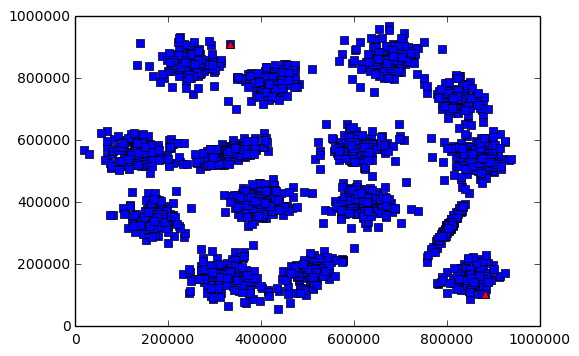

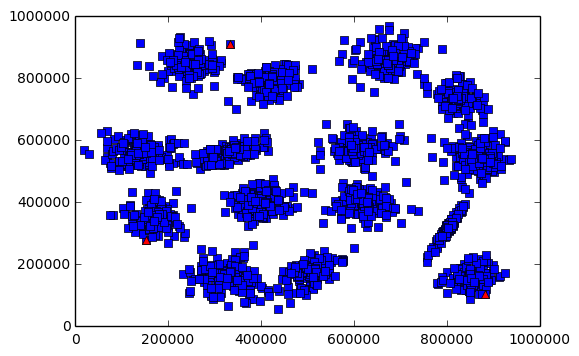

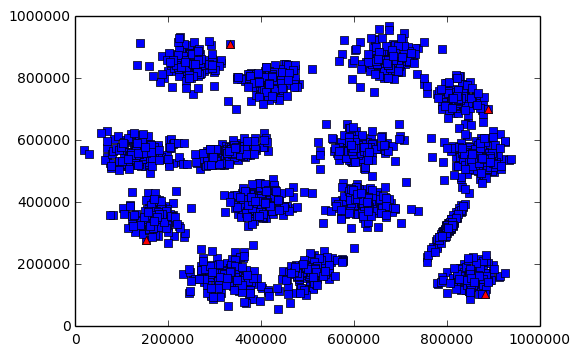

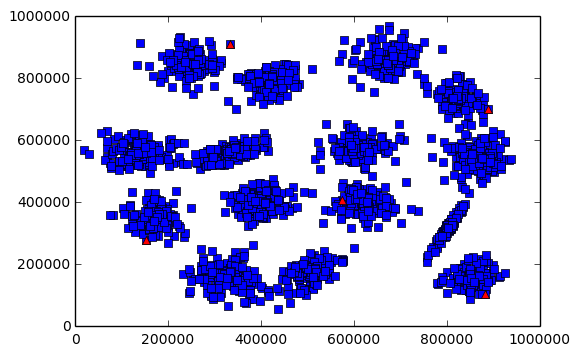

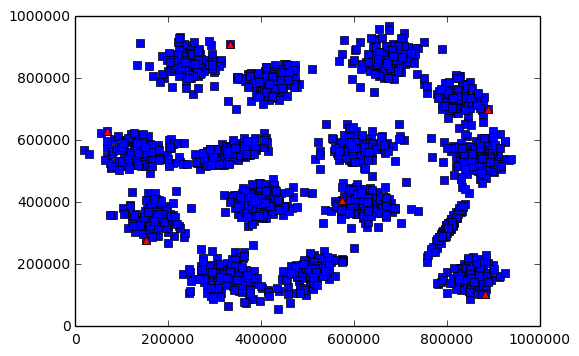

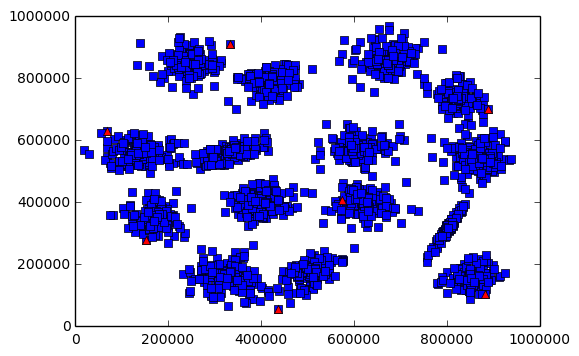

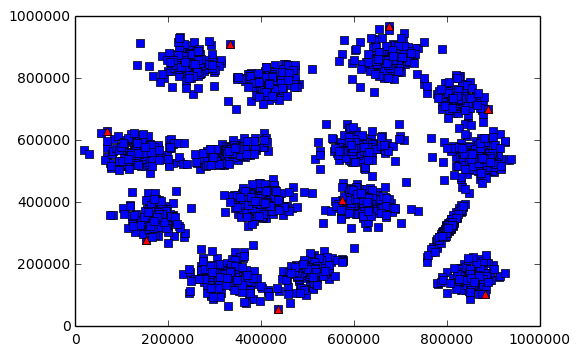

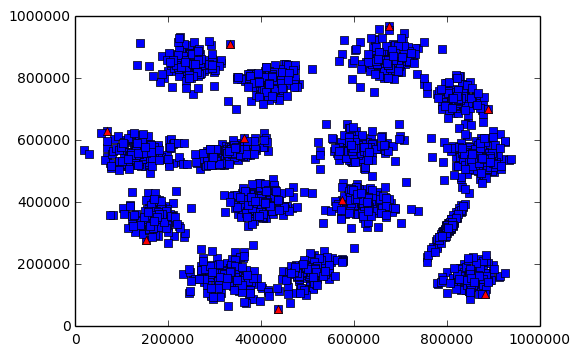

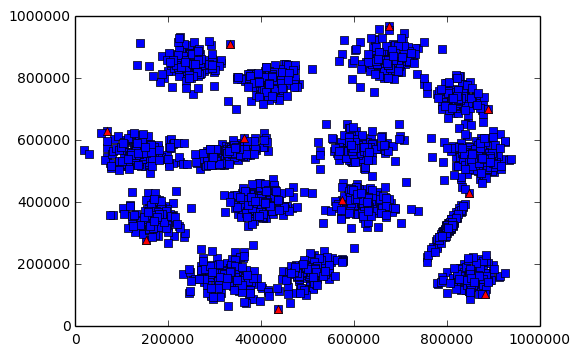

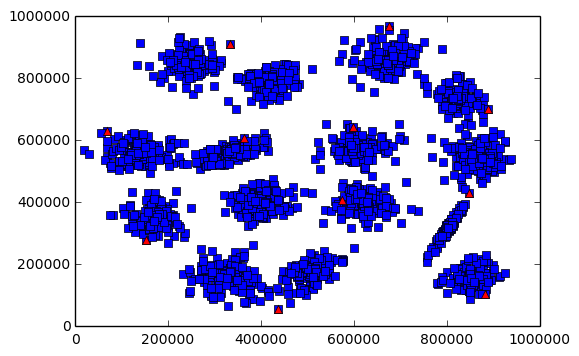

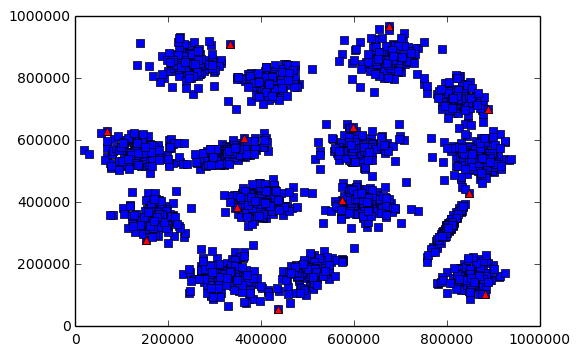

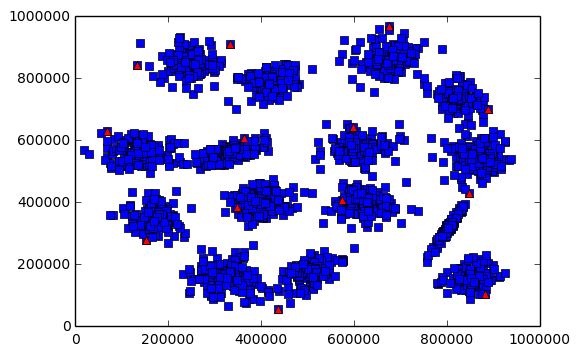

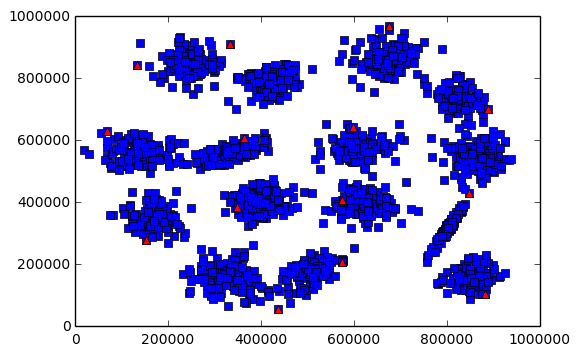

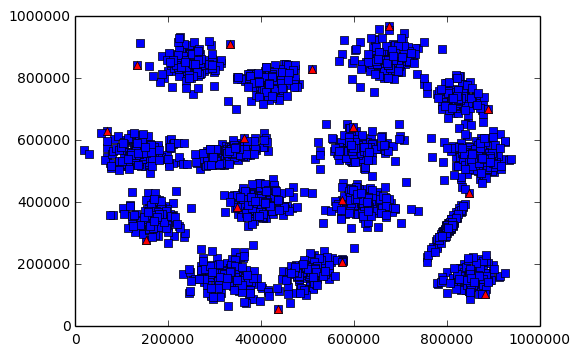

In [64]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)




--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


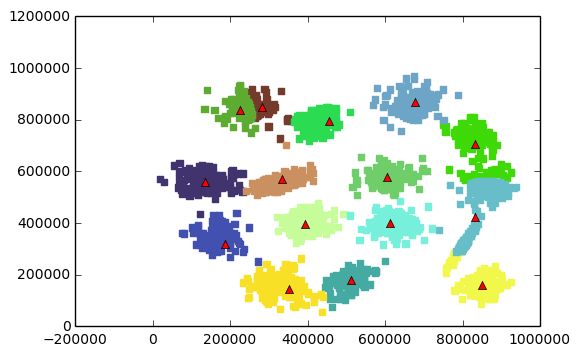

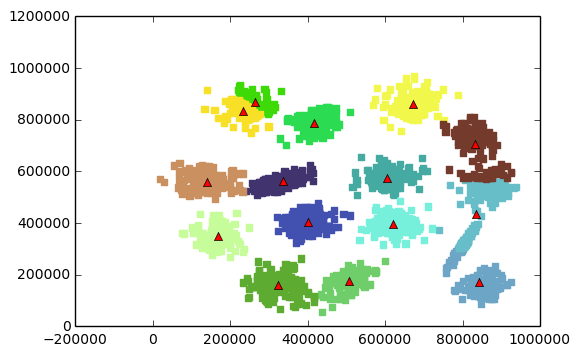

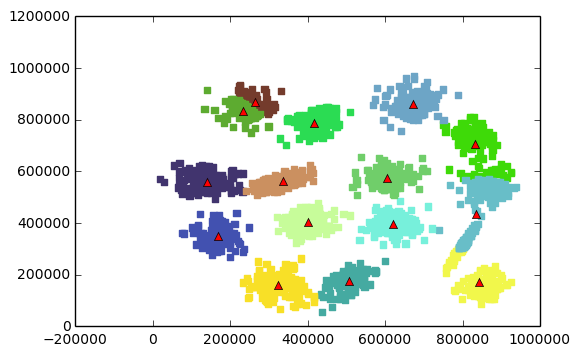

In [65]:
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)

Intialisation avec le random puis kmeans, on observe des resultats moins bon

Initial cluster center :  (332237, 911313) 

Current cluster points : [(332237, 911313)]

 Cluster list :  [(332237, 911313), (645677, 814395)]

 New cluster point : (645677, 814395)
Current cluster points : [(332237, 911313), (645677, 814395)]

 Cluster list :  [(332237, 911313), (645677, 814395), (701017, 931252)]

 New cluster point : (701017, 931252)
Current cluster points : [(332237, 911313), (645677, 814395), (701017, 931252)]

 Cluster list :  [(332237, 911313), (645677, 814395), (701017, 931252), (588933, 366439)]

 New cluster point : (588933, 366439)
Current cluster points : [(332237, 911313), (645677, 814395), (701017, 931252), (588933, 366439)]

 Cluster list :  [(332237, 911313), (645677, 814395), (701017, 931252), (588933, 366439), (650661, 861267)]

 New cluster point : (650661, 861267)
Current cluster points : [(332237, 911313), (645677, 814395), (701017, 931252), (588933, 366439), (650661, 861267)]

 Cluster list :  [(332237, 911313), (645677, 814395), (701017, 931252)

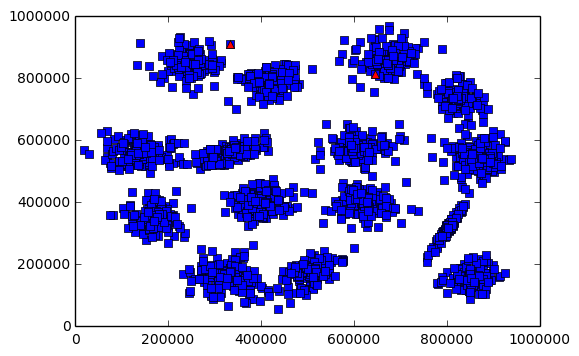

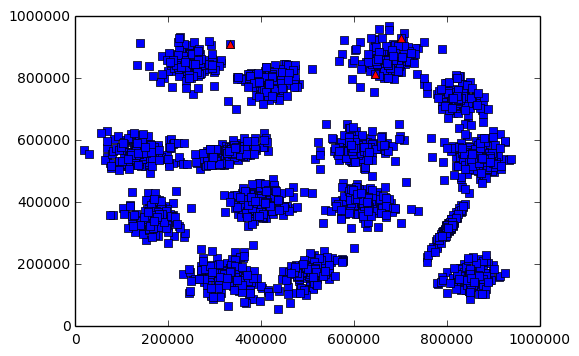

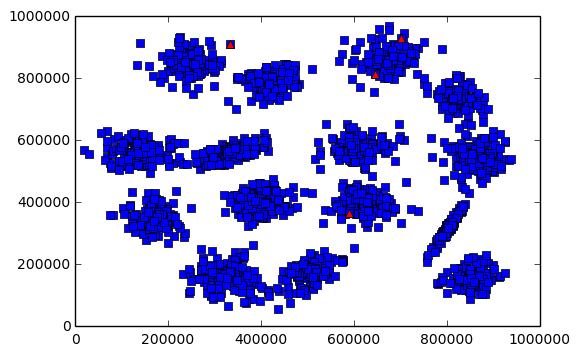

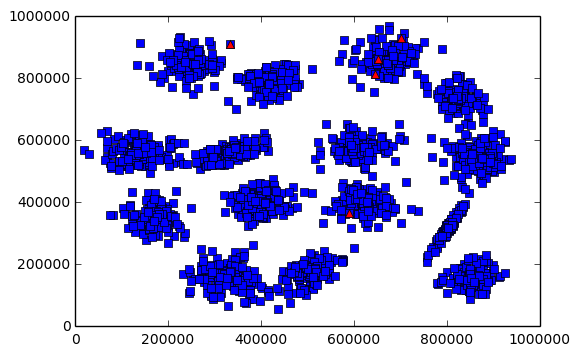

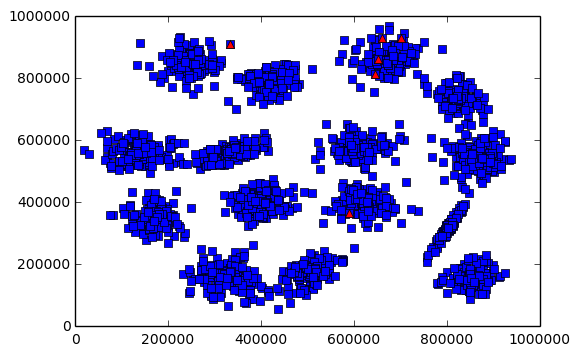

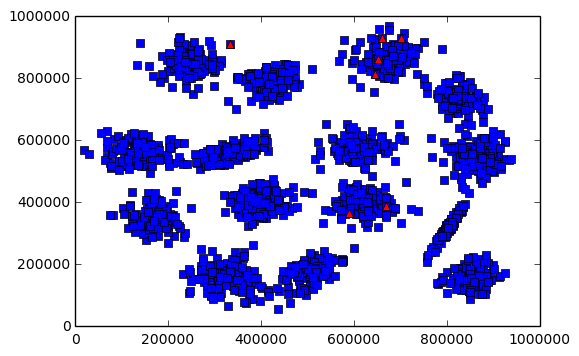

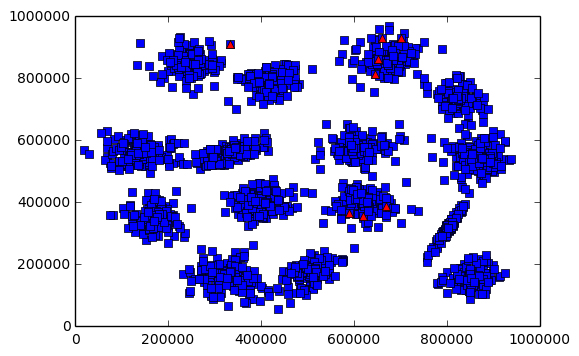

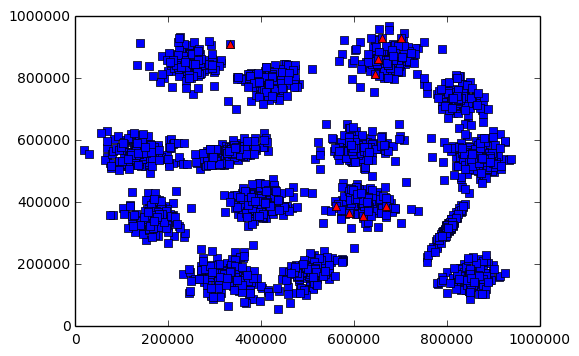

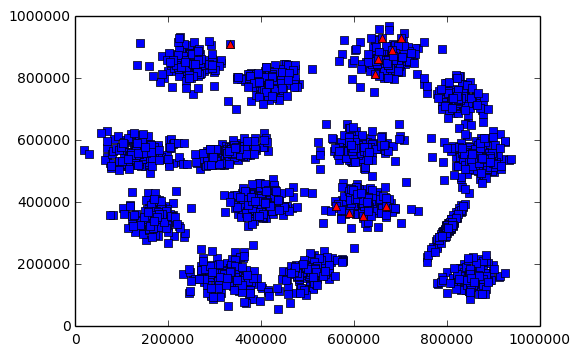

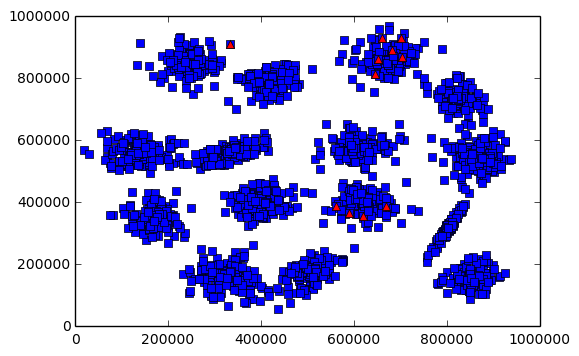

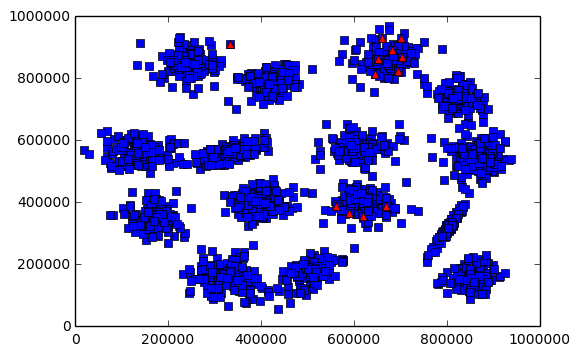

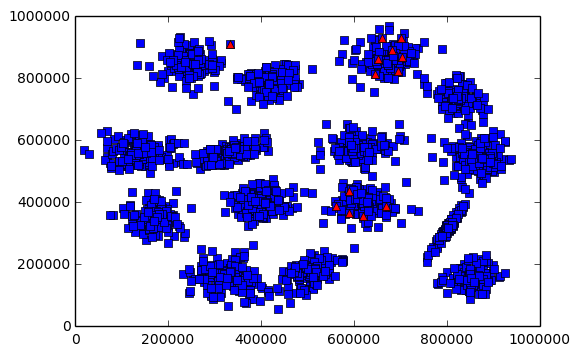

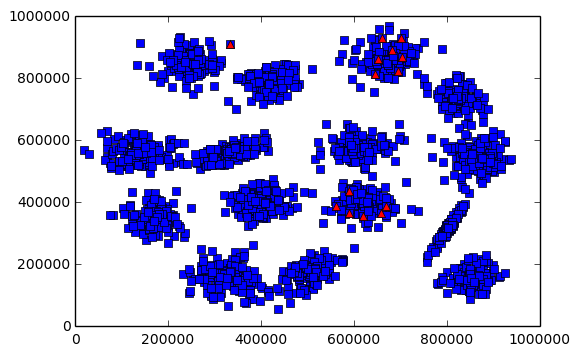

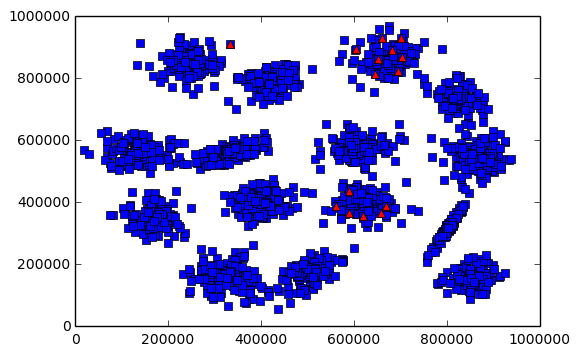

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


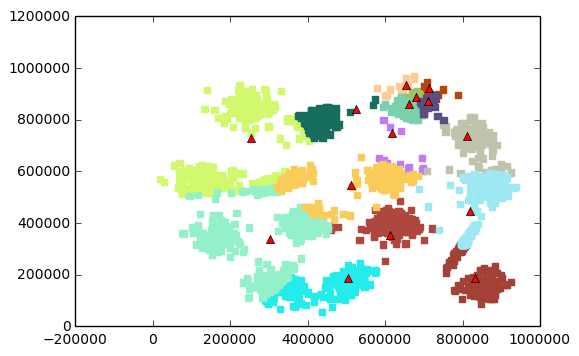

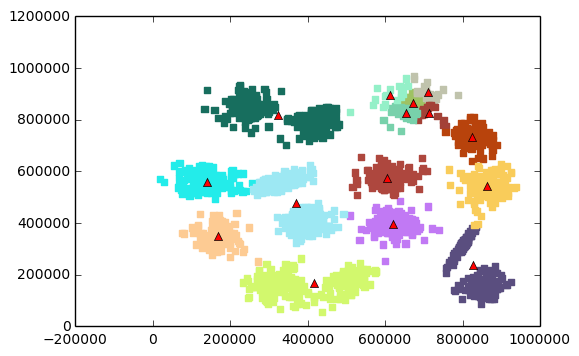

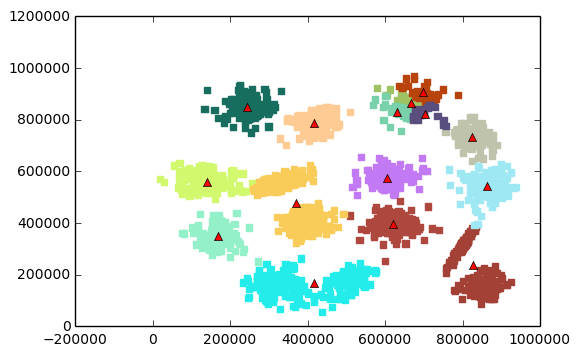

In [66]:
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMaxWithRandom, cluster_centers=cluster_centers, visualize=True)
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)


Initialisation avec le kmeans++ pas optimisé pour être distribué correctement, mais exact, resultat correct mais pas mal de temps en theorie

Initial cluster center :  (332237, 911313) 

Current cluster points : [(332237, 911313)]
Data zip [(0, (665845, 557965, 332237, 911313, 485951.7535393817)), (1, (597173, 575538, 332237, 911313, 427710.10593742115)), (2, (618600, 551446, 332237, 911313, 459900.01680582704))]
Data zip map [(0, 485951.7535393817), (1, 427710.10593742115), (2, 459900.01680582704)]
Data to extract max dist [485951.7535393817, 427710.10593742115, 459900.01680582704]
Full cumulative sum is  :  1331001423.271865
Data zip map normalized  [(0, 0.00036510235454505837), (1, 0.0003213445894640932), (2, 0.00034552932007788674)]
[(0, 0.00036510235454505837), (1, 0.0003213445894640932), (2, 0.00034552932007788674)]
[0, 1, 2]
[0.00036510235454505837, 0.0003213445894640932, 0.00034552932007788674]
1.0000000000000009
Draw :  0.6417444529496474
Cumsum 0 0.000365102354545
Best point  [(1649, (176602, 574552, 332237, 911313, 370985.4772710112))]
(176602, 574552)

 Cluster list :  [(332237, 911313), (176602, 574552)]

 New c

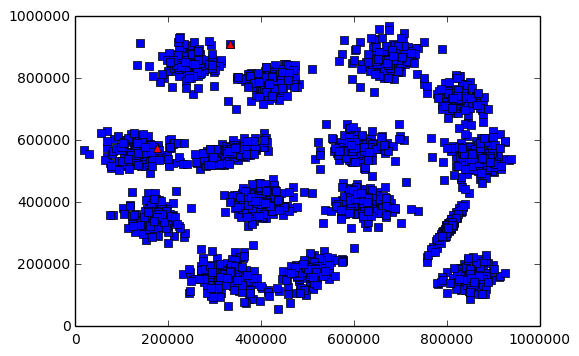

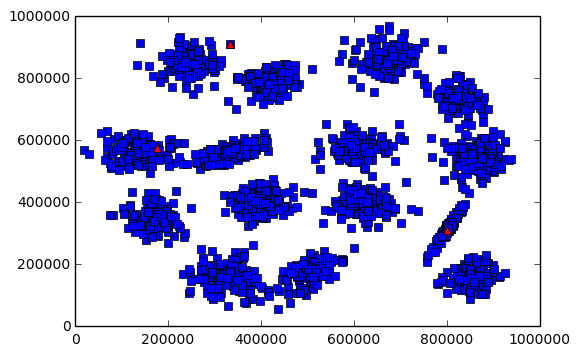

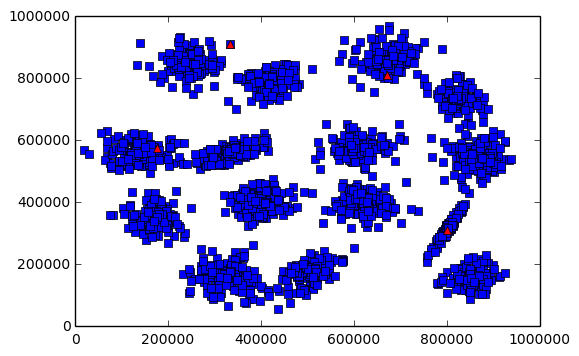

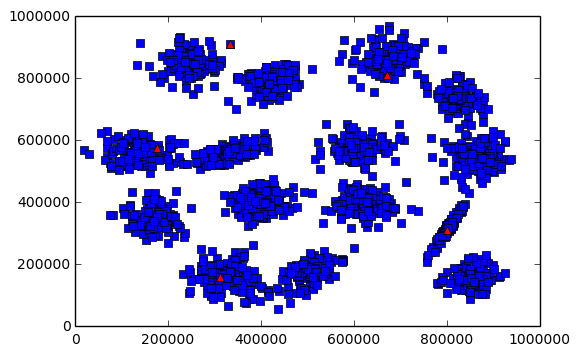

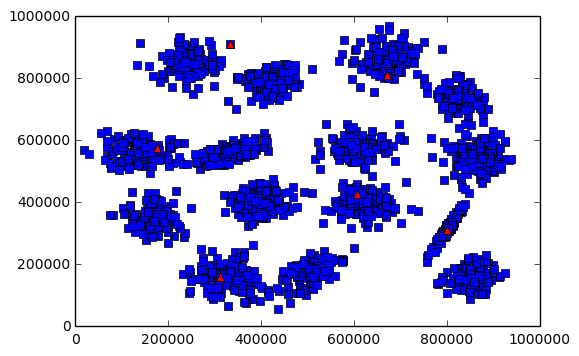

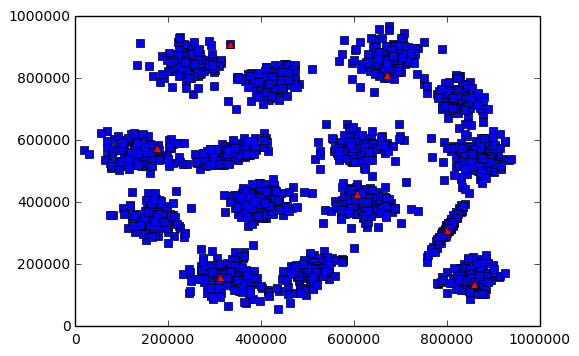

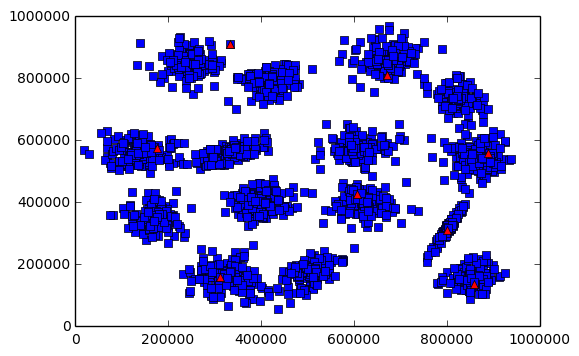

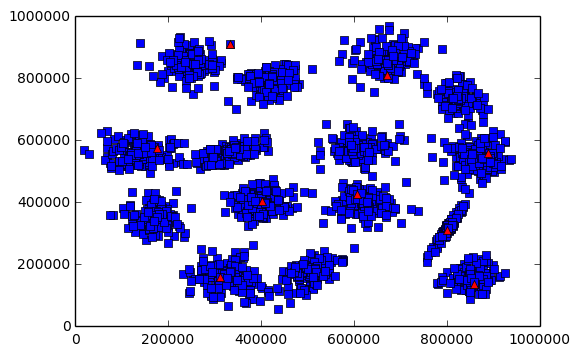

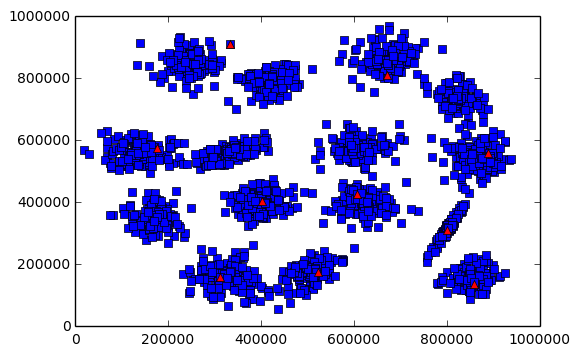

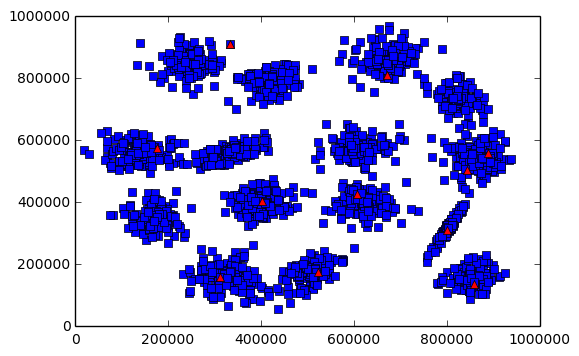

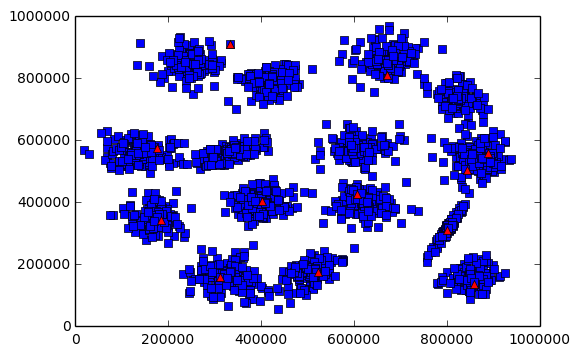

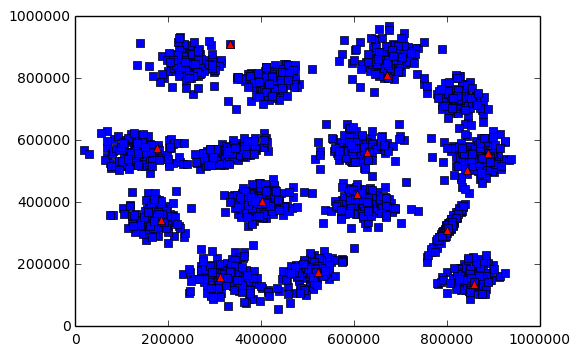

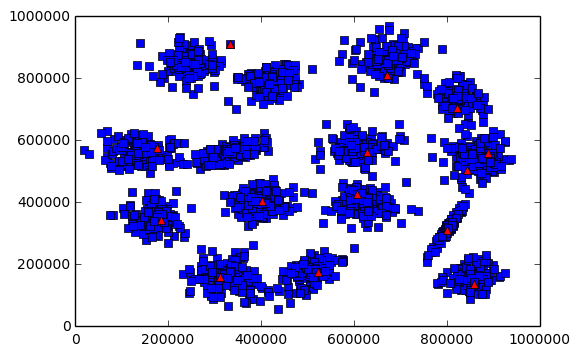

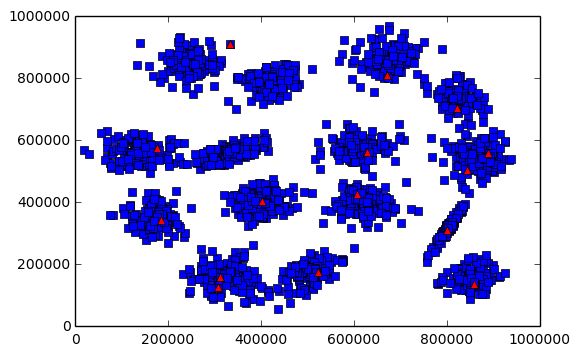

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


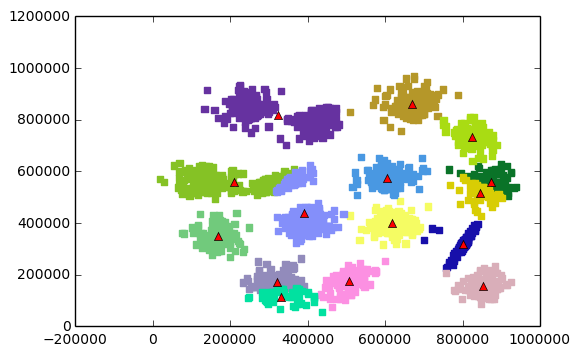

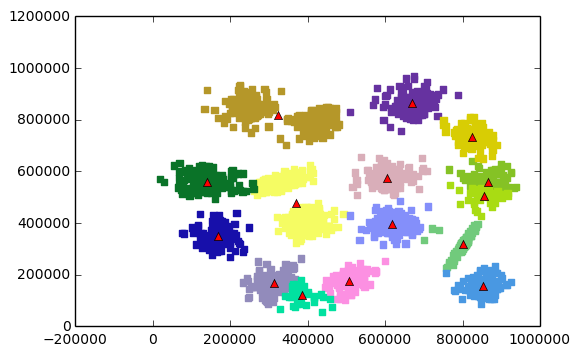

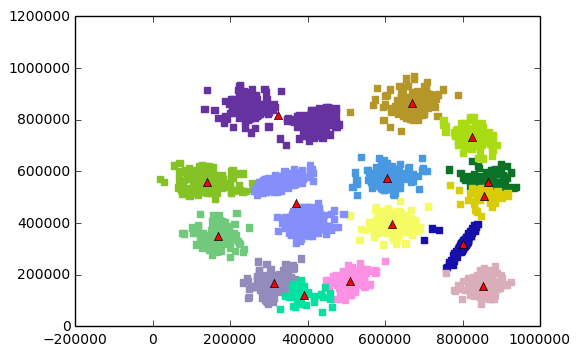

In [67]:
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")


s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=15, reducer=reduceMaxWithRandom, cluster_centers=cluster_centers, distributed=False, visualize=True)
kmeans_result = kmeans(s1_map_clustered, cluster_centers, num_iterations=30, num_features=2, visualize=True)

